# Will try to use the Bird plate boundary table to determine if plate boundary is on-land or under water

Created and tested by A. Newman on 9/01/2022
* updated: A. Newman 11/8/2023

## Map first

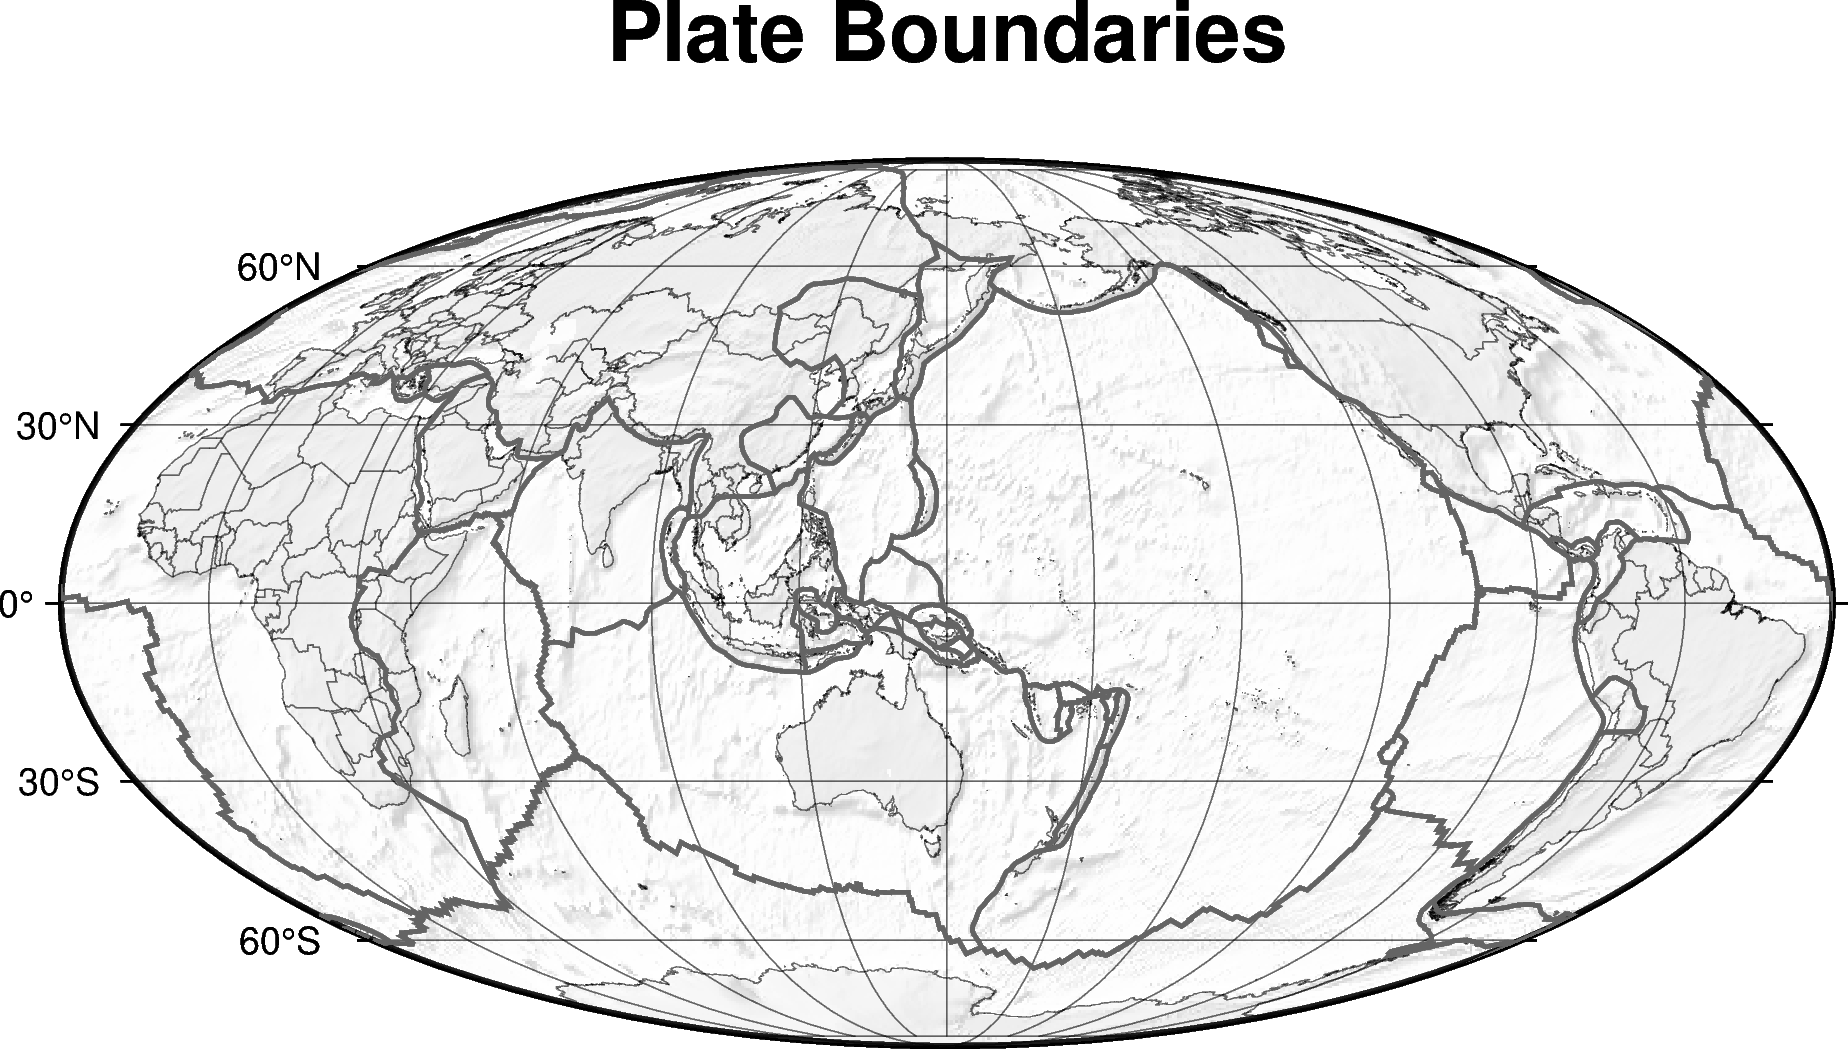

In [1]:
import pygmt,os
scale=15
clon=150
libdir=os.path.join(os.getcwd(),'mapdata')
grid = pygmt.datasets.load_earth_relief(resolution="30m")

#Plates
plates=os.path.join(libdir,'PB2002_plates.txt') # global plate DB
proj="W"+str(clon)+"/"+str(scale)+"c" 
mapcpt=os.path.join(libdir,'map_gray.cpt') # use my favorite light shade


fig1=pygmt.Figure()
fig1.coast(projection=proj,  #pacific-centric w/o chopping Africa
           frame=['WSen+tPlate Boundaries','xa30', 'ya30'], 
           water='white',land='white', shorelines='1/0p,white',
           region='g',
           resolution='c'
          )

fig1.grdimage(grid=grid, cmap=mapcpt, shading=True, 
                  projection=proj,transparency=70)
fig1.coast(projection=proj,  #pacific-centric w/o chopping Africa
           frame=['WSen+tPlate Boundaries','xag30', 'yag30'], 
           shorelines='1/0.2p',
           resolution='l', 
           borders=1,
           transparency=40
          )
fig1.plot(data=plates, pen='1,100', transparency=0)

fig1.show()

In [2]:
# read db
import pandas as pd
platedf=pd.read_csv(plates,delimiter='\s+',skiprows=10,comment='>',names=['Long','Lat'])

# IS land?
# found on stack exchange
import cartopy.io.shapereader as shpreader
import shapely.geometry as sgeom
from shapely.ops import unary_union
from shapely.prepared import prep
land_shp_fname = shpreader.natural_earth(resolution='50m',
                    category='physical', name='land')

land_geom = unary_union(list(shpreader.Reader(land_shp_fname).geometries()))
land = prep(land_geom)

# define is_land
def is_land(x, y):
    return land.contains(sgeom.Point(x, y))

<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
/Users/an77/tmp/ipykernel_31373/2200235155.py:3: SyntaxWarning: invalid escape sequence '\s'
  platedf=pd.read_csv(plates,delimiter='\s+',skiprows=10,comment='>',names=['Long','Lat'])


In [3]:
nland=0; nsea=0
platedf=platedf.assign(IsLand='')

for i, row in platedf.iterrows():
    if is_land(platedf.Long[i],platedf.Lat[i]):
        nland=nland+1
        platedf.at[i,"IsLand"]=True
    else:
        nsea=nsea+1
        platedf.at[i,"IsLand"]=False
        
fracSeaByCount=nsea/(nsea+nland)*100 
fracLandByCount=nland/(nsea+nland)*100 

In [4]:
import  pyproj
dland=0; dsea=0
dmax=100 # km
npts=len(platedf.index)
platedf=platedf.assign(Length=0)
platedf=platedf.assign(LengthUsed='')


geod = pyproj.Geod(ellps='WGS84')
for i, row in platedf.iterrows():
    if i < npts-1: # don't iterate on last point since we're doing lengths between points
        az, baz, dist = geod.inv(  # distance is in meters
             platedf.Long[i],platedf.Lat[i], 
             platedf.Long[i+1],platedf.Lat[i+1])
        dist=dist/1e3 # convert to km
        platedf.at[i,"Length"]=int(dist)  # want integer distances in km
        if dist < dmax:  # only if less than threshold (avoid jumping boundaries)
            platedf.at[i,"LengthUsed"]=True
            if platedf.IsLand[i]:
                dland=dland+dist
            else:
                dsea=dsea+dist
        else:
            platedf.at[i,"LengthUsed"]=False
            
        
print(dland/1e3,dsea/1e3,dsea/(dland+dsea))
fracSeaByLength=dsea/(dsea+dland)*100 
fracLandByLength=dland/(dsea+dland)*100 

92.48843741418857 422.0157021158213 0.820237719566892


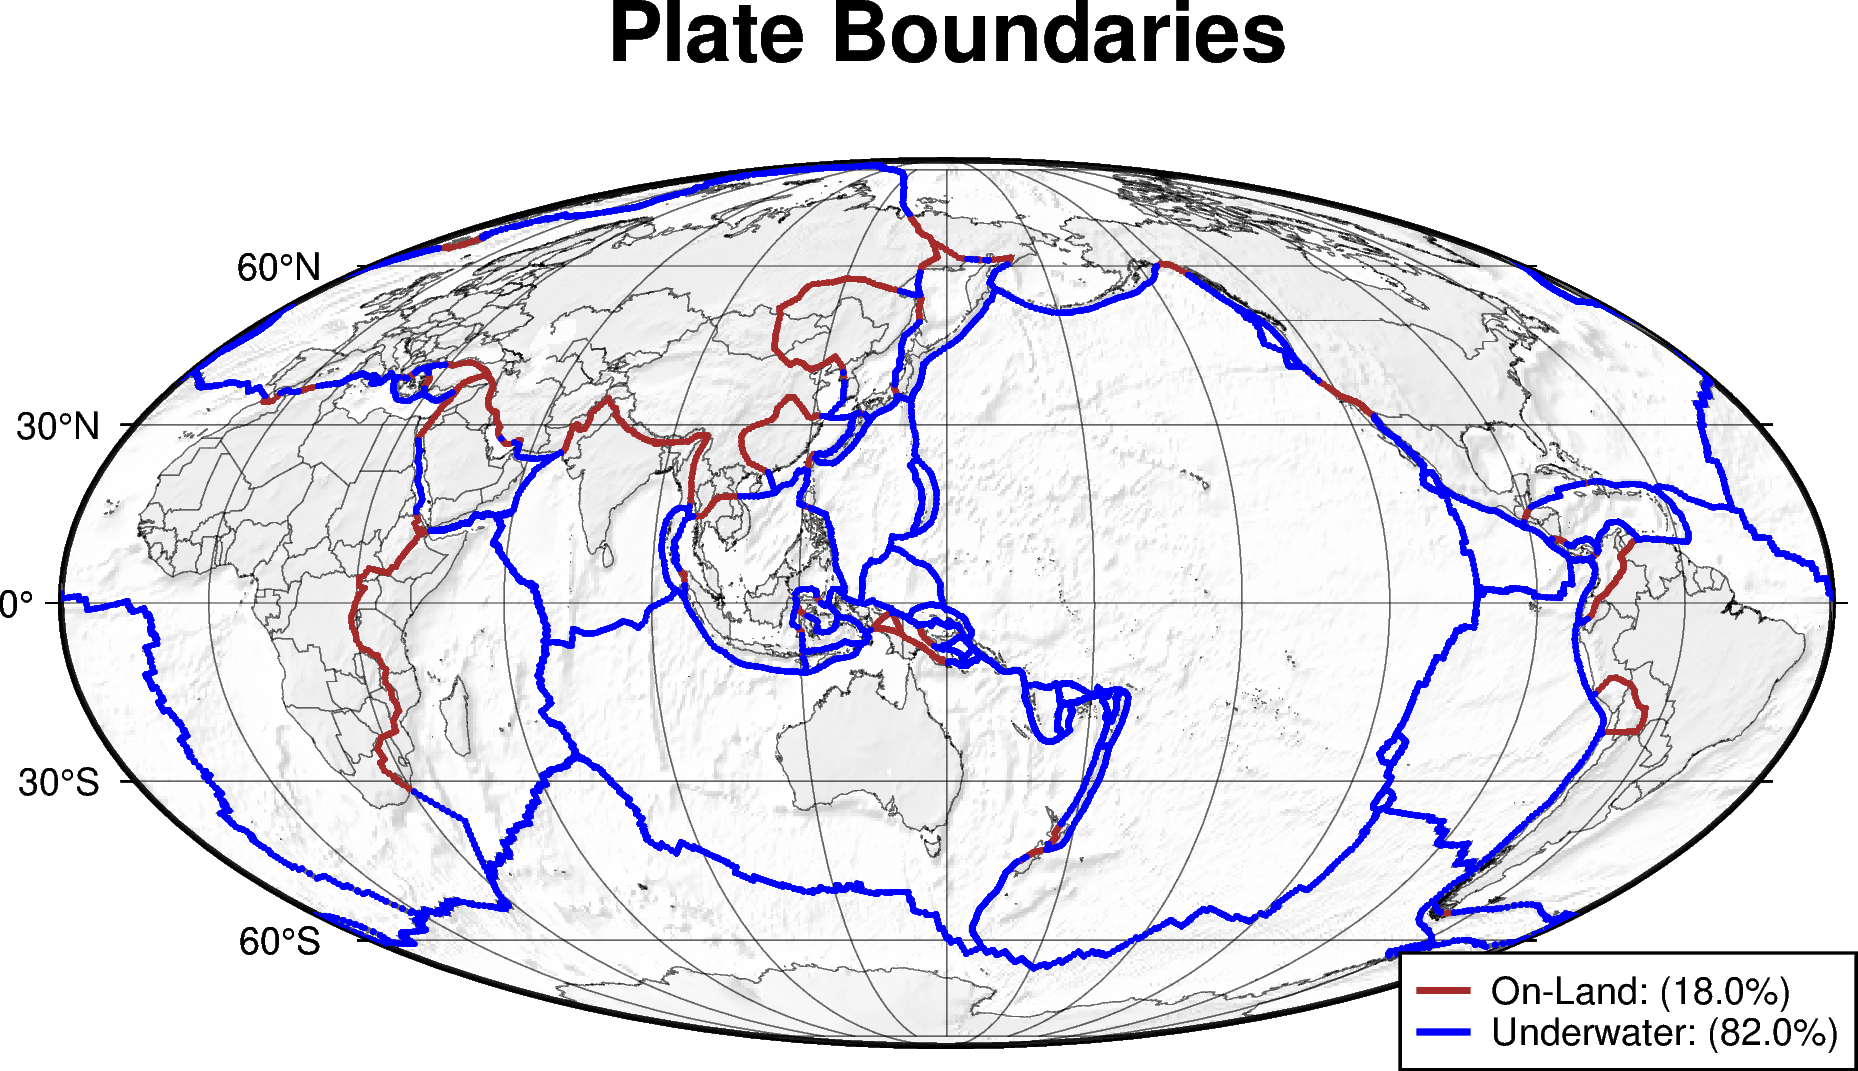

In [5]:
sz=0.05
dgreen='0/180/0'

#fig1.plot(platedf[platedf['LengthUsed']==True].loc[:,['Long','Lat']], 
#          style='p'+str(sz*3)+'c', color='orange', transparency=50)


fig1.plot(platedf[platedf['IsLand']==True].loc[:,['Long','Lat']], 
          style='p'+str(sz)+'c', fill='brown', transparency=0)
fig1.plot(platedf[platedf['IsLand']==False].loc[:,['Long','Lat']], 
          style='p'+str(sz)+'c', fill='blue', transparency=0)


# lines just for legend (plotting under legend)
fig1.plot(x=195,y=-70,pen='1.5p,brown', 
          label="On-Land: ("+"%.1f" % fracLandByLength +"%)")
fig1.plot(x=195,y=-70,pen='1.5p,blue', 
          label="Underwater: ("+"%.1f" % fracSeaByLength +"%)")

fig1.legend(position='JBR+jBR+o-0.2c',
           box='+gwhite+p0.7p',
           )
fig1.show()

In [6]:
fig1.savefig('UnderWater_PlateBoundaries.png',
            dpi=300,
            anti_alias=True,
            #transparent=True,
            show=True)

##  Add global GNSS stations to plot
GNSS='http://geodesy.unr.edu/NGLStationPages/DataHoldings.txt'

There are more than 20,000 stations to plot which can really slow things down....you've been warned

In [7]:
import numpy as np
# read from UNR skipping header and only pulling Lat and Lon columns
GNSS=np.loadtxt('http://geodesy.unr.edu/NGLStationPages/DataHoldings.txt', skiprows=1, usecols=(1,2))

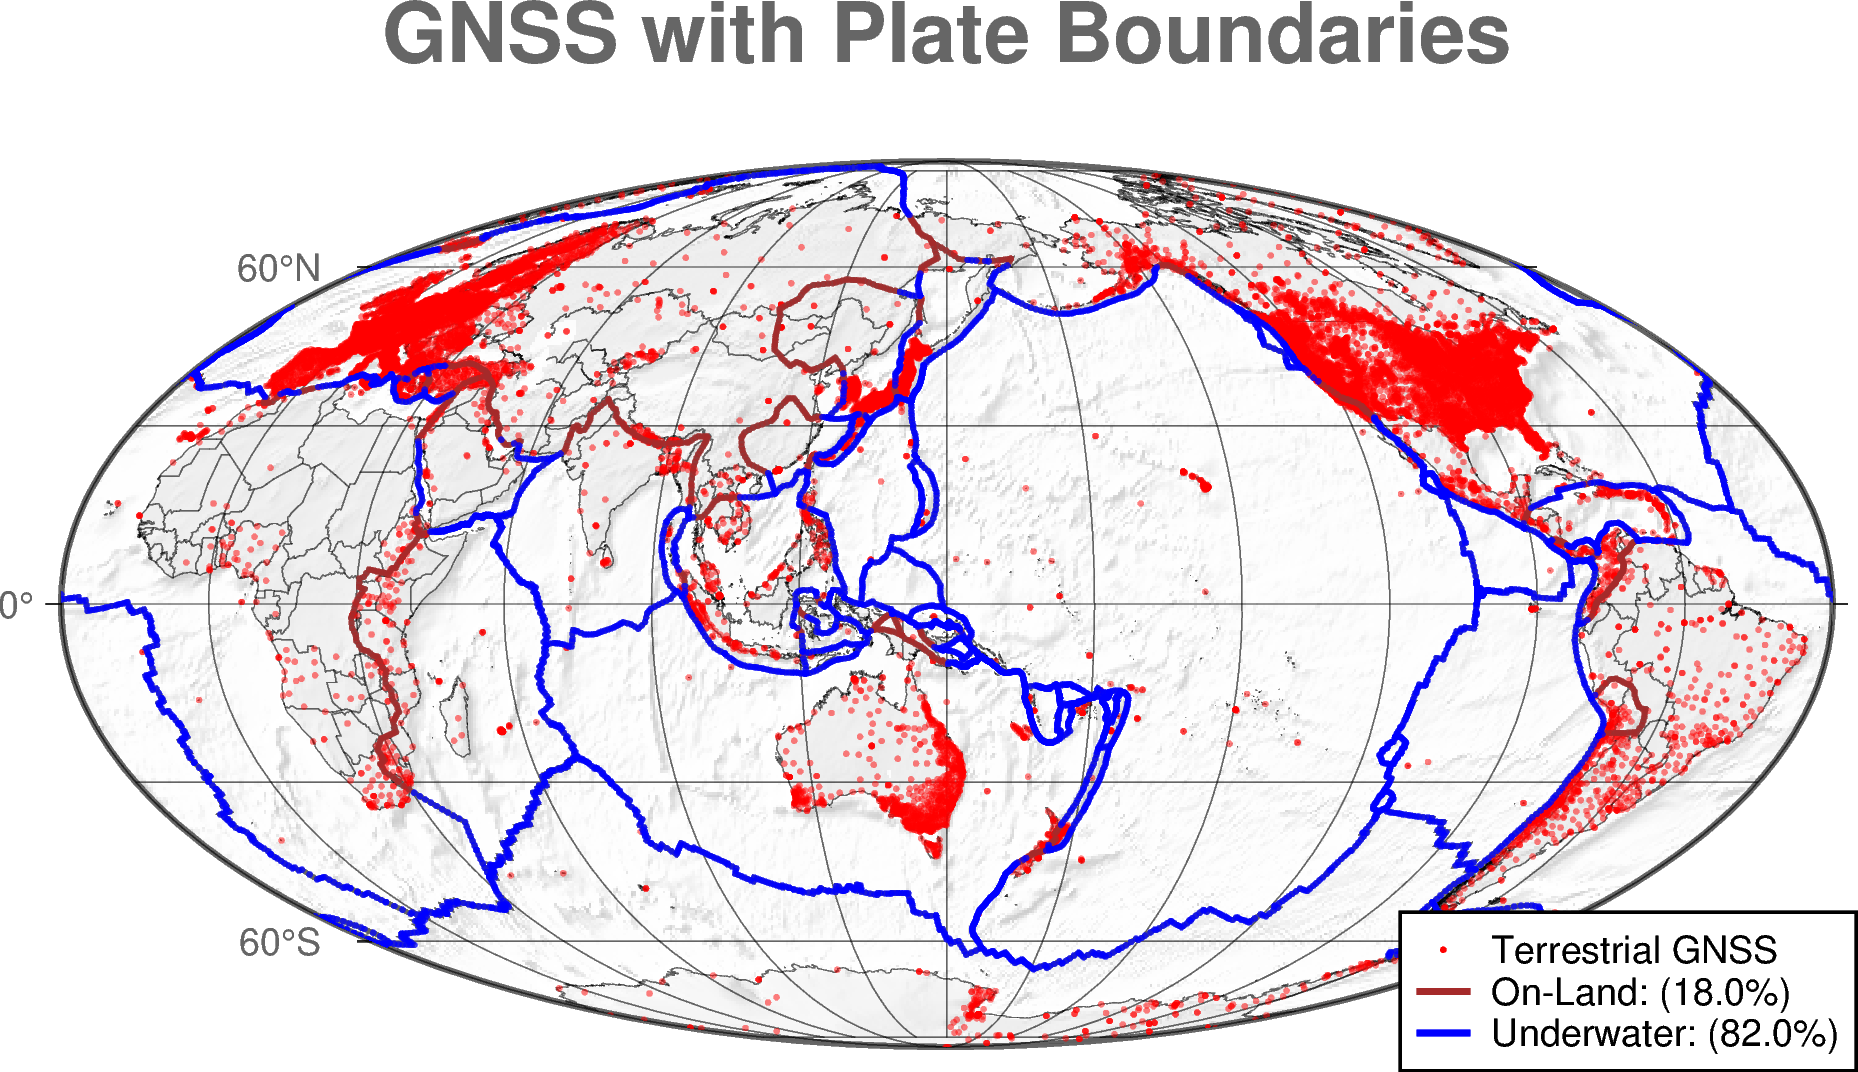

In [8]:
sz=0.05

fig2=pygmt.Figure()
fig2.grdimage(grid=grid, cmap=mapcpt, shading=True, 
                  projection=proj,transparency=70)
fig2.coast(projection=proj,  #pacific-centric w/o chopping Africa
           frame=['WSen+tGNSS with Plate Boundaries','xag30', 'yag30'], 
           shorelines='1/0.2p',
           resolution='l', 
           borders=1,
           transparency=40
          )
fig2.plot(data=plates, pen='1,100', transparency=0)

fig2.plot(x=GNSS.T[1],y=GNSS.T[0],
         style="c0.05c", fill='red',transparency=50,
         label='Terrestrial GNSS'
         )

fig2.plot(platedf[platedf['IsLand']==True].loc[:,['Long','Lat']], 
          style='p'+str(sz)+'c', fill='brown', transparency=50)
fig2.plot(platedf[platedf['IsLand']==False].loc[:,['Long','Lat']], 
          style='p'+str(sz)+'c', fill='blue', transparency=50)


# lines just for legend (plotting under legend)
fig2.plot(x=195,y=-70,pen='1.5p,brown', transparency=40,
          label="On-Land: ("+"%.1f" % fracLandByLength +"%)")
fig2.plot(x=195,y=-70,pen='1.5p,blue',  transparency=40,
          label="Underwater: ("+"%.1f" % fracSeaByLength +"%)")

fig2.legend(position='JBR+jBR+o-0.2c',
           box='+gwhite+p0.7p',
           )

fig2.show()

In [9]:
fig2.savefig('UnderWater_PlateBoundaries_wGPS.pdf',
            dpi=300,
            anti_alias=True,
            #transparent=True,
            show=True)